In [6]:
from tensorflow.keras import Sequential
#rom tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import models
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import math
import random
import tensorflow as tf

In [2]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
img_width, img_height = 224, 224  # Default input size for VGG16

img_window = (img_width, img_height, 3)
batch_size =  256


In [4]:
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [58]:
train_data = preprocessing.image_dataset_from_directory(
    directory = './training_folder/',
    validation_split=0.2,
    labels="inferred",
    label_mode='categorical',    
    color_mode="rgb",
    subset="training",
    class_names = ['background', "faces"],
    batch_size= batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    seed = 0,
    
)

validation_data = preprocessing.image_dataset_from_directory(
    directory = './training_folder/',
    validation_split=0.2,
    labels="inferred",
    label_mode='categorical' ,    
    color_mode="rgb",
    class_names = ['background', "faces"],
    subset="validation",
    batch_size= int(batch_size*2),
    image_size=(img_width, img_height),
    shuffle=True,
    seed = 0,
    
)

Found 8274 files belonging to 2 classes.
Using 6620 files for training.
Found 8274 files belonging to 2 classes.
Using 1654 files for validation.


In [88]:
image_batch, labels_batch = next(iter(train_data))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,255]`.
print(np.min(first_image), np.max(first_image))

0.0 254.79492


In [60]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [61]:
train_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_data.map(lambda x, y: (normalization_layer(x), y))

In [62]:
#After Normalization 

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.022426464 0.54732955


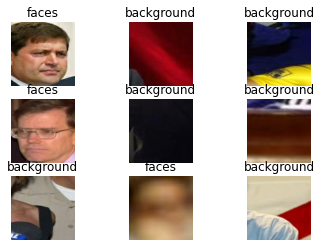

In [65]:
class_names = {0:"background", 1:'faces'}
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    ind = np.argmax(labels[i].numpy())
    plt.title(class_names[ind])
    plt.axis("off")
  



In [92]:
img_number = len(list(glob('./training_folder/*/*')))
sample_count_train = math.ceil(img_number*0.8)
sample_count_validation = img_number - sample_count_train

In [ ]:
conv_base.trainable = False

In [5]:

def extract_features(dataset, sample_count, batch_size_dataset):
    
    features = np.zeros(shape=(sample_count, 7, 7, 512), dtype='float32') # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,2), dtype='float32')  
    
    i= 0
    for image_batch, labels_batch in dataset:

        features_batch = conv_base.predict(image_batch)

        features[i * batch_size_dataset: (i + 1) * batch_size_dataset] = features_batch
        labels[i * batch_size_dataset: (i + 1) *batch_size_dataset] = labels_batch

        i += 1
        if i * batch_size_dataset >= sample_count:
                break

    return features, labels


In [ ]:
train_features, train_labels = extract_features(train_ds, sample_count_train, batch_size)
validation_features, validation_labels = extract_features(validation_ds, sample_count_validation, int(batch_size*2))

In [8]:
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(7,7,512)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
      
  ]
)


In [9]:
model = Sequential([ 
  data_augmentation,
  layers.Flatten(input_shape=(7,7,512)),
  layers.Dense(256,  kernel_initializer='he_uniform',activation='relu', input_dim=(7*7*512)),
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 6,423,298
Trainable params: 6,423,298
Non-trainable params: 0
_________________________________________________________________


In [99]:
checkpointer = callbacks.ModelCheckpoint(filepath='model_transferLearningVGG16BS.hdf5', monitor='val_accuracy',verbose=1, save_weights_only=False,save_best_only=True)

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', "AUC"])

In [100]:

history = model.fit(train_features, train_labels, epochs= epochs, validation_data=(validation_features, validation_labels), callbacks=[checkpointer])


Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8767 - auc: 0.9457
Epoch 00001: val_accuracy improved from -inf to 0.91475, saving model to model_transferLearningVGG16BS.hdf5
207/207 [==============================] - 15s 72ms/step - loss: 0.3234 - accuracy: 0.8767 - auc: 0.9457 - val_loss: 0.1905 - val_accuracy: 0.9148 - val_auc: 0.9781
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9024 - auc: 0.9687
Epoch 00002: val_accuracy improved from 0.91475 to 0.92261, saving model to model_transferLearningVGG16BS.hdf5
207/207 [==============================] - 15s 73ms/step - loss: 0.2265 - accuracy: 0.9024 - auc: 0.9687 - val_loss: 0.1989 - val_accuracy: 0.9226 - val_auc: 0.9798
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9139 - auc: 0.9734
Epoch 00003: val_accuracy did not improve from 0.92261
207/207 [==============================] - 14s 69ms/step - loss: 0

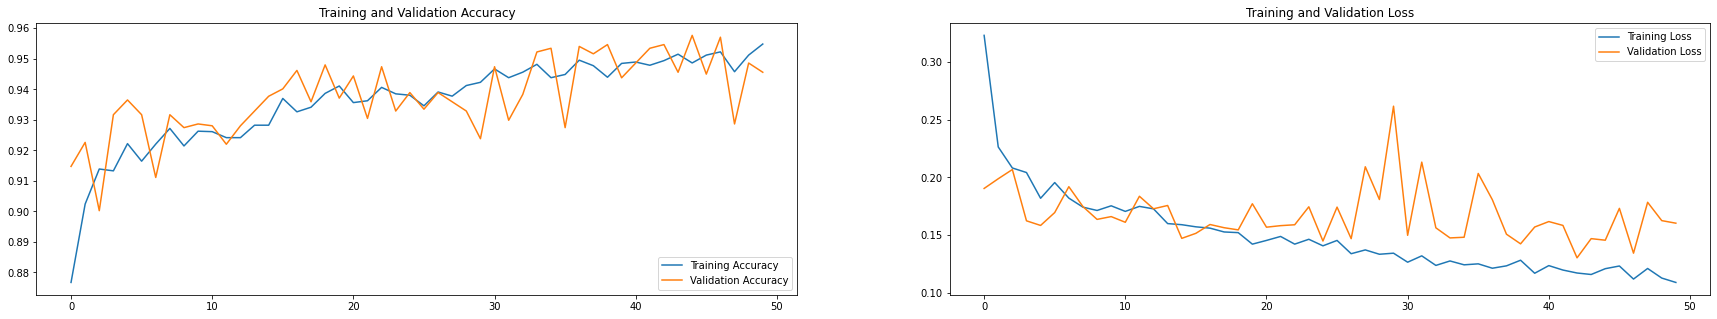

In [101]:
#vizualise
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model = models.load_model("model_transferLearningVGG16BS.hdf5")

In [123]:
test_data = preprocessing.image_dataset_from_directory(
    directory = './TESTSET/',
    labels="inferred",
    label_mode='categorical',    
    color_mode="rgb",
    class_names = ['background', "faces"],
    batch_size=256,
    image_size=(img_width, img_height),
    shuffle=False,
)
    

Found 2204 files belonging to 2 classes.


In [16]:
test_ds_fddb = test_data.map(lambda x, y: (normalization_layer(x), y))

In [17]:
test_features_fddb, test_labels_fddb = extract_features(test_ds_fddb, len(list(glob('./TESTSET/*/*'))), 256)

In [18]:
score = model.evaluate(test_features_fddb, test_labels_fddb)

69/69 [==============================] - 0s 6ms/step - loss: 0.2287 - accuracy: 0.9229 - auc: 0.9757


In [20]:
dict_class = {'faces':1, 'background': 0}

def labels(files_img):
    
    y = []
    
    for img_path in files_img:
        y.append(dict_class.get(img_path.split("\\")[-2]))
       
    return y

In [21]:
files_img = glob('./TESTSET/*/*')
y_fddb = labels(files_img)

preds= model.predict(test_features_fddb, batch_size=256)
y_pred_fddb = np.argmax(preds, axis = 1)

In [22]:
print("accuracy is "+str(score[1]))
print("f1 is "+str(f1_score(y_fddb,y_pred_fddb)))
print("recall is "+str(recall_score(y_fddb,y_pred_fddb)))
print("precision is "+str(precision_score(y_fddb,y_pred_fddb)))
print("AUC is "+str(score[2]))

accuracy is 0.9228675365447998
f1 is 0.9234234234234234
recall is 0.8768177929854577
precision is 0.9752616555661275
AUC is 0.9756737947463989


In [42]:
class_names = {0:"background", 1:'faces'}
y_test, y_pred_test = [], []

for images, labels in zip(test_features_fddb, test_labels_fddb):
 
    
    ind= np.argmax(labels)
    images = np.expand_dims(images, axis=0)
   
    y_test.append(ind)
    pred = model.predict(images)
    y_pred_test.append(np.argmax(pred))
    
    
  



In [46]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, y_pred_test)

print(m.result().numpy())

0.92286754


# Test the model trained with FDDB dataset, using AVDIA dataset

In [23]:
test_data = preprocessing.image_dataset_from_directory(
    directory = './TestAVDIAR/',
    labels="inferred",
    label_mode='categorical',    
    color_mode="rgb",
    class_names = ['background', "faces"],
    batch_size=64,
    image_size=(img_width, img_height),
    shuffle=False,
)
    

Found 10604 files belonging to 2 classes.


In [24]:
test_ds = test_data.map(lambda x, y: (normalization_layer(x), y))

In [25]:
test_features, test_labels = extract_features(test_ds, len(list(glob('./TestAVDIAR/*/*'))), 64)

In [26]:
score = model.evaluate(test_features, test_labels)

332/332 [==============================] - 2s 7ms/step - loss: 0.2192 - accuracy: 0.9023 - auc: 0.9711


In [27]:
preds= model.predict(test_features, batch_size=64)
y_pred = np.argmax(preds, axis = 1)

In [28]:
files_img = glob('./TestAVDIAR/*/*')
y = labels(files_img)

In [29]:
print("accuracy is "+str(score[1]))
print("f1 is "+str(f1_score(y,y_pred)))
print("recall is "+str(recall_score(y,y_pred)))
print("precision is "+str(precision_score(y,y_pred)))
print("AUC is "+str(score[2]))

accuracy is 0.902301013469696
f1 is 0.8936344969199178
recall is 0.8208223311957752
precision is 0.9806219017575485
AUC is 0.9710803627967834


# RE-TRAIN AND RE-EVALUATE MODEL USING AVDIAR DATASET

# MEMORY PROBLEM :( :( BUT GOT GOOD RESULTS WITH FDDB TRAINING

In [6]:
train_data = preprocessing.image_dataset_from_directory(
    directory = './DatasetAVDIAR/',
    validation_split=0.2,
    labels="inferred",
    label_mode='categorical',    
    color_mode="rgb",
    subset="training",
    class_names = ['background', "faces"],
    batch_size= batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    seed = 0,
    
)

validation_data = preprocessing.image_dataset_from_directory(
    directory = './DatasetAVDIAR/',
    validation_split=0.2,
    labels="inferred",
    label_mode='categorical' ,    
    color_mode="rgb",
    class_names = ['background', "faces"],
    subset="validation",
    batch_size= int(batch_size*2),
    image_size=(img_width, img_height),
    shuffle=True,
    seed = 0,
    
)

Found 143762 files belonging to 2 classes.
Using 115010 files for training.
Found 143762 files belonging to 2 classes.
Using 28752 files for validation.


In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_data.map(lambda x, y: (normalization_layer(x), y))

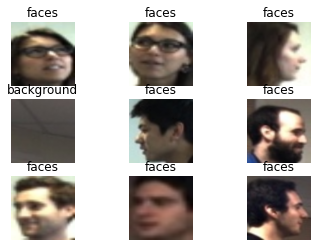

In [8]:
class_names = {0:"background", 1:'faces'}
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    ind = np.argmax(labels[i].numpy())
    plt.title(class_names[ind])
    plt.axis("off")
  



In [9]:
img_number = len(list(glob('./DatasetAVDIAR/*/*')))
sample_count_train = math.ceil(img_number*0.8)
sample_count_validation = img_number - sample_count_train
print(sample_count_train)

115010


In [ ]:
train_features_avdiar, train_labels_avdiar = extract_features(train_ds, sample_count_train, batch_size)
validation_features_avdiar, validation_labels_avdiar = extract_features(validation_ds, sample_count_validation, int(batch_size*2))

In [202]:
checkpointer = callbacks.ModelCheckpoint(filepath='model_transferLearningVGG16_AVDIAR.hdf5', monitor='val_accuracy',verbose=1, save_weights_only=False,save_best_only=True)

In [ ]:
model_avdiar = Sequential([ 
  layers.Flatten(input_shape=(7,7,512)),
  layers.Dense(256,  kernel_initializer='he_uniform',activation='relu', input_dim=(7*7*512)),
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
])

model.summary()

In [ ]:
model_avdiar.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', "AUC"])
history_avdiar = model_avdiar.fit(train_features_avdiar, train_labels_avdiar, batch_size = 512, epochs= epochs, validation_data=(validation_features_avdiar, validation_labels_avdiar), callbacks=[checkpointer])


In [ ]:
#vizualise
acc = history_avdiar.history['accuracy']
val_acc = history_avdiar.history['val_accuracy']

loss = history_avdiar.history['loss']
val_loss = history_avdiar.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
score_avdiar = model_avdiar.evaluate(test_features, test_labels)

In [ ]:
preds= model_avdiar.predict(test_features, batch_size=64)
y_pred_avdiar = np.argmax(preds, axis = 1)

In [ ]:
print("accuracy is "+str(score_avdiar[1]))
print("f1 is "+str(f1_score(y,y_pred_avdiar)))
print("recall is "+str(recall_score(y,y_pred_avdiar)))
print("precision is "+str(precision_score(y,y_pred_avdiar)))
print("AUC is "+str(score_avdiar[2]))